# HW 4

- *by Harit Jaiswal*

#### Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce

import pickle


In [2]:
def vol_ohlc(df, lookback=10):
    o = df.open
    h = df.high
    l = df.low
    c = df.close
    
    k = 0.34 / (1.34 + (lookback+1)/(lookback-1))
    cc = np.log(c/c.shift(1))
    ho = np.log(h/o)
    lo = np.log(l/o)
    co = np.log(c/o)
    oc = np.log(o/c.shift(1))
    oc_sq = oc**2
    cc_sq = cc**2
    rs = ho*(ho-co)+lo*(lo-co)
    close_vol = cc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    open_vol = oc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    window_rs = rs.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    result = (open_vol + k * close_vol + (1-k) * window_rs).apply(np.sqrt) * np.sqrt(252)
    result.iloc[:lookback-1] = np.nan
    
    return result

In [3]:
def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
    scoring=None
):
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
        scoring=scoring,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    fit_time_argsort = fit_times_mean.argsort()
    fit_time_sorted = fit_times_mean[fit_time_argsort]
    test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
    test_scores_std_sorted = test_scores_std[fit_time_argsort]
    axes[2].grid()
    axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
    axes[2].fill_between(
        fit_time_sorted,
        test_scores_mean_sorted - test_scores_std_sorted,
        test_scores_mean_sorted + test_scores_std_sorted,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

#### Get data


In [4]:
data_location = 'sqlite:///spdr.db'
ohlc = pd.read_sql('SELECT * FROM ohlc_spdr', data_location)

In [5]:
print('table shape=', ohlc.shape)
print('unique tickers=', ohlc.ticker.unique())
display('table head=', ohlc.head())
display('table stats=', ohlc.describe())


table shape= (67914, 8)
unique tickers= ['SPY' 'XLC' 'XLY' 'XLP' 'XLE' 'XLF' 'XLV' 'XLI' 'XLB' 'XLRE' 'XLK' 'XLU']


'table head='

,ts,open,high,low,close,adj_close,volume,ticker
0,1993-01-29 00:00:00,43.96875,43.96875,43.75000,43.93750,24.840677,1003200.0,SPY
1,1993-02-01 00:00:00,43.96875,44.25000,43.96875,44.25000,25.017349,480500.0,SPY
2,1993-02-02 00:00:00,44.21875,44.37500,44.12500,44.34375,25.070364,201300.0,SPY
3,1993-02-03 00:00:00,44.40625,44.84375,44.37500,44.81250,25.335377,529400.0,SPY
4,1993-02-04 00:00:00,44.96875,45.09375,44.46875,45.00000,25.441385,531500.0,SPY


'table stats='

,open,high,low,close,adj_close,volume
count,67914.000000,67914.000000,67914.000000,67914.000000,67914.000000,6.791400e+04
mean,61.287238,61.714136,60.824372,61.287955,51.072376,2.080120e+07
std,60.536420,60.888511,60.158273,60.547446,58.197864,4.669763e+07
min,4.914703,5.239643,4.776604,5.020309,3.809756,0.000000e+00
25%,27.906250,28.110001,27.670000,27.890625,19.040798,1.674725e+06
50%,39.750000,40.020000,39.400002,39.745001,31.360975,6.782550e+06
75%,71.739998,72.234999,71.197498,71.739998,61.243898,1.499645e+07
max,479.220001,479.980011,476.260010,477.709991,476.690002,1.050592e+09


#### Data formatting

In [6]:
def format_data(table):
    tickers = table.ticker.unique()

    def df_merge(left, right):
        return pd.merge(left, right, on='ts', how='inner')

    X = reduce(df_merge, [
        (lambda df: 
        (
            df
            .assign(
                vol=vol_ohlc(df, lookback=5).fillna(0),
                cret=df.adj_close.pct_change(),
                vo_lag_1=vol_ohlc(df, lookback=5).fillna(0).shift(1),
                vol_lag_5=vol_ohlc(df, lookback=5).fillna(0).shift(5),
                vol_lag_10=vol_ohlc(df, lookback=5).fillna(0).shift(10),
                vol_lag_15=vol_ohlc(df, lookback=5).fillna(0).shift(15),
            )[['ts', 'vol', 'cret', 'vo_lag_1', 'vol_lag_5', 'vol_lag_10', 'vol_lag_15']]
            .rename(columns={
                col: f'{col}_{ticker}' for col in ['ts', 'vol', 'cret', 'vo_lag_1', 'vol_lag_5', 'vol_lag_10', 'vol_lag_15'] if col != 'ts'
            })
        ))(table[table.ticker == ticker])
        for ticker in tickers
    ]).set_index('ts')
    
    return X

In [7]:
X = format_data(ohlc)

In [8]:
print('X.shape=', X.shape)
print('X.columns=', X.columns)
display('X.tail()', X.tail())

X.shape= (1393, 72)
X.columns= Index(['vol_SPY', 'cret_SPY', 'vo_lag_1_SPY', 'vol_lag_5_SPY',
       'vol_lag_10_SPY', 'vol_lag_15_SPY', 'vol_XLC', 'cret_XLC',
       'vo_lag_1_XLC', 'vol_lag_5_XLC', 'vol_lag_10_XLC', 'vol_lag_15_XLC',
       'vol_XLY', 'cret_XLY', 'vo_lag_1_XLY', 'vol_lag_5_XLY',
       'vol_lag_10_XLY', 'vol_lag_15_XLY', 'vol_XLP', 'cret_XLP',
       'vo_lag_1_XLP', 'vol_lag_5_XLP', 'vol_lag_10_XLP', 'vol_lag_15_XLP',
       'vol_XLE', 'cret_XLE', 'vo_lag_1_XLE', 'vol_lag_5_XLE',
       'vol_lag_10_XLE', 'vol_lag_15_XLE', 'vol_XLF', 'cret_XLF',
       'vo_lag_1_XLF', 'vol_lag_5_XLF', 'vol_lag_10_XLF', 'vol_lag_15_XLF',
       'vol_XLV', 'cret_XLV', 'vo_lag_1_XLV', 'vol_lag_5_XLV',
       'vol_lag_10_XLV', 'vol_lag_15_XLV', 'vol_XLI', 'cret_XLI',
       'vo_lag_1_XLI', 'vol_lag_5_XLI', 'vol_lag_10_XLI', 'vol_lag_15_XLI',
       'vol_XLB', 'cret_XLB', 'vo_lag_1_XLB', 'vol_lag_5_XLB',
       'vol_lag_10_XLB', 'vol_lag_15_XLB', 'vol_XLRE', 'cret_XLRE',
       'vo_lag_1_X

'X.tail()'

,vol_SPY,cret_SPY,vo_lag_1_SPY,vol_lag_5_SPY,vol_lag_10_SPY,vol_lag_15_SPY,vol_XLC,cret_XLC,vo_lag_1_XLC,vol_lag_5_XLC,...,vo_lag_1_XLK,vol_lag_5_XLK,vol_lag_10_XLK,vol_lag_15_XLK,vol_XLU,cret_XLU,vo_lag_1_XLU,vol_lag_5_XLU,vol_lag_10_XLU,vol_lag_15_XLU
ts,,,,,,,,,,,,,,,,,,,,,
2023-12-22 00:00:00,0.128693,0.002010,0.133849,0.107519,0.118461,0.091053,0.171595,0.000138,0.171193,0.140023,...,0.154056,0.134667,0.173019,0.145195,0.173567,0.003365,0.205023,0.250697,0.147727,0.163567
2023-12-26 00:00:00,0.123559,0.004223,0.128693,0.114852,0.086773,0.121676,0.161187,0.003856,0.171595,0.143356,...,0.149241,0.133703,0.132272,0.183956,0.158750,0.006068,0.173567,0.260461,0.133393,0.173581
2023-12-27 00:00:00,0.122910,0.001808,0.123559,0.111590,0.085528,0.123103,0.158523,0.000137,0.161187,0.141158,...,0.142412,0.127533,0.128533,0.186557,0.155162,-0.000635,0.158750,0.254027,0.143862,0.165918
2023-12-28 00:00:00,0.096539,0.000378,0.122910,0.126532,0.087311,0.119778,0.121723,0.002743,0.158523,0.165025,...,0.146054,0.135667,0.121831,0.183282,0.138252,0.007147,0.155162,0.220723,0.199660,0.159971
2023-12-29 00:00:00,0.072901,-0.002895,0.096539,0.133849,0.095365,0.120952,0.097511,-0.006019,0.121723,0.171193,...,0.130329,0.154056,0.127703,0.177414,0.125436,-0.001262,0.138252,0.205023,0.221389,0.158877


#### Separating X and Y variables

X.shape= (1388, 72)
y.shape= (1388,)


'y.describe'

count    1388.000000
mean        0.255628
std         0.165073
min         0.062725
25%         0.163958
50%         0.220199
75%         0.299540
max         2.064559
Name: vol_XLK, dtype: float64

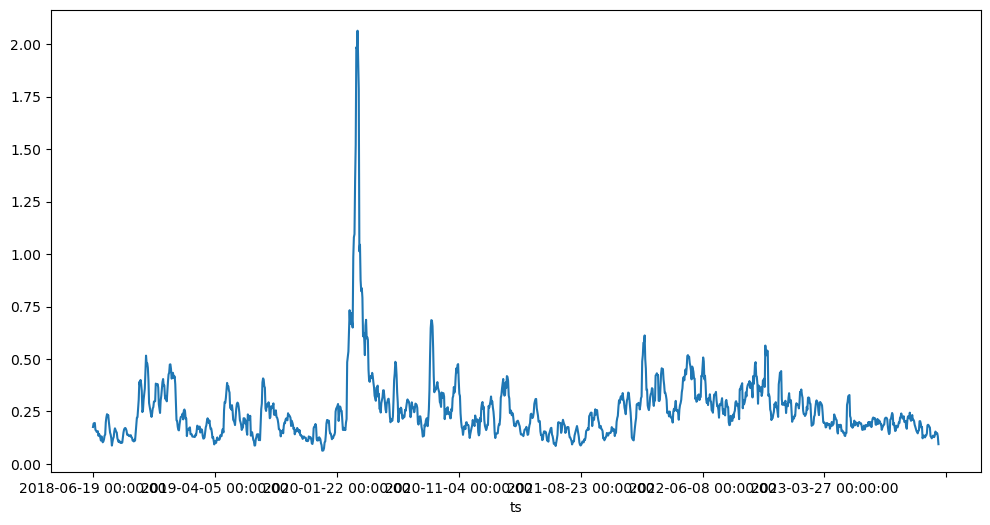

In [9]:
y = X.vol_XLK.shift(-5)[:-5]
X = X[:-5]

plt.figure(figsize=(12, 6))
y.plot().figure

print('X.shape=', X.shape)
print('y.shape=', y.shape)
display('y.describe', y.describe())


#### Checking autocorrelation of y(XLK's volatility in 5 days)

(1.0, 50.0)

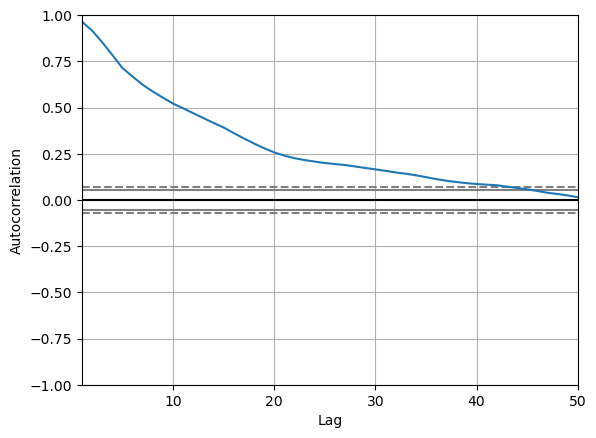

In [10]:
from pandas.plotting import scatter_matrix, autocorrelation_plot

autocorrelation_plot(y[1:]).set_xlim([1, 50])

#### Check on nulls

In [11]:
null_counts = pd.isnull(X).sum()
null_counts[null_counts > 0]

cret_XLC           1
vo_lag_1_XLC       1
vol_lag_5_XLC      5
vol_lag_10_XLC    10
vol_lag_15_XLC    15
dtype: int64

#### Checking pair-wise correlation between columns

In [12]:
{col: y.corr(X[col]) for col in X.columns if X[col].dtype != 'object'}

{'vol_SPY': 0.7134699099998555,
 'cret_SPY': -0.17392498017137406,
 'vo_lag_1_SPY': 0.6670530759824088,
 'vol_lag_5_SPY': 0.515221824656508,
 'vol_lag_10_SPY': 0.3825685378037027,
 'vol_lag_15_SPY': 0.24943152614826053,
 'vol_XLC': 0.6595170916771003,
 'cret_XLC': -0.14284324170926851,
 'vo_lag_1_XLC': 0.6122683545519062,
 'vol_lag_5_XLC': 0.4619568573752814,
 'vol_lag_10_XLC': 0.34093666620034146,
 'vol_lag_15_XLC': 0.21105301450345354,
 'vol_XLY': 0.6799315779640431,
 'cret_XLY': -0.17623413706684588,
 'vo_lag_1_XLY': 0.6325260632718196,
 'vol_lag_5_XLY': 0.486846058899086,
 'vol_lag_10_XLY': 0.363921711966154,
 'vol_lag_15_XLY': 0.24138313406267564,
 'vol_XLP': 0.7071712950367174,
 'cret_XLP': -0.11608784380824869,
 'vo_lag_1_XLP': 0.656031385140956,
 'vol_lag_5_XLP': 0.4853735338664226,
 'vol_lag_10_XLP': 0.32741078154890535,
 'vol_lag_15_XLP': 0.20197688907107164,
 'vol_XLE': 0.6566647682081362,
 'cret_XLE': -0.15792268835883772,
 'vo_lag_1_XLE': 0.6038491133495518,
 'vol_lag_5_XL

#### Setting up the model

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

from sklearn.model_selection import cross_validate
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, make_scorer

from sklearn.model_selection import learning_curve

class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.columns]
    
    
def evaluate_model(model, X, y, test_size=0.2):
    cv = TimeSeriesSplit(n_splits=int(y.shape[0] * test_size), test_size=3)
    scorer = make_scorer(mean_squared_error, greater_is_better=False, squared=False)
    
    return np.mean(cross_validate(model, X, y, cv=cv, scoring=scorer, n_jobs=-1)['test_score'])


#### RandomForest model

In [14]:
pipeline = Pipeline([
    ('impute', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0.)),
    ('scale', StandardScaler()),
    # ('pca', PCA(n_components=5)),
    ('model', RandomForestRegressor(n_estimators=100, random_state=0))
])
    
evaluate_model(pipeline, X, y)

-0.06099273138077525

Random Forest with KNN imputer

In [15]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=2, weights="uniform")

pipeline = Pipeline([
    ('impute', KNNImputer(n_neighbors=2, weights="uniform")),
    ('scale', StandardScaler()),
    # ('pca', PCA(n_components=5)),
    ('model', RandomForestRegressor(n_estimators=100, random_state=0))
])
    
evaluate_model(pipeline, X, y)

-0.06081825921116124

Random Forest with PCA

In [16]:
pipeline = Pipeline([
    ('impute', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0.)),
    ('scale', StandardScaler()),
    ('pca', PCA(n_components=10)),
    ('model', RandomForestRegressor(n_estimators=100, random_state=0))
])

evaluate_model(pipeline, X, y)

-0.06487173195935438

Reducing dimesnionality using PCA doesn't seem to improve the score.

#### XGBoost regression

In [17]:
from xgboost import XGBRegressor

pipeline = Pipeline([
    ('impute', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0.)),
    ('scale', StandardScaler()),
    # ('pca', PCA(n_components=5)),
    ('model', XGBRegressor(n_estimators=100))
])

evaluate_model(pipeline, X, y)

-0.06473994276387128

#### Ridge regression

In [18]:
pipeline = Pipeline([
    ('impute', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0.)),
    ('scale', StandardScaler()),
    # ('pca', PCA(n_components=5)),
    ('model', Ridge(alpha=1.0))
])

evaluate_model(pipeline, X, y)

-0.0788273593735845

#### Lasso regression

In [19]:
pipeline = Pipeline([
    ('impute', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0.)),
    ('scale', StandardScaler()),
    # ('pca', PCA(n_components=5)),
    ('model', Lasso(alpha=0.1))
])

evaluate_model(pipeline, X, y)

-0.07382132830896371

#### ElasticNet regression

In [20]:
pipeline = Pipeline([
    ('impute', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0.)),
    ('scale', StandardScaler()),
    # ('pca', PCA(n_components=5)),
    ('model', ElasticNet(alpha=0.01, l1_ratio=0.5))
])

evaluate_model(pipeline, X, y)

-0.06570889602808483

RandomForest regression model with KNN imputer is the best. So we can use it and optimize hyperparameters for it.

#### Hyperparameter tuning

In [21]:
from sklearn.model_selection import GridSearchCV

pipeline = Pipeline([
    ('feature_selector', FeatureSelector(columns=None)),
    ('impute', KNNImputer(n_neighbors=2)),
    ('scale', StandardScaler()),
    ('pca', PCA()),
    ('model', RandomForestRegressor())
])

test_size = 0.2
cv = TimeSeriesSplit(n_splits=int(y.shape[0] * test_size), test_size=1)
scorer = make_scorer(mean_squared_error, greater_is_better=False, squared=False)

search = GridSearchCV(pipeline, {
    'feature_selector__columns': [[col for col in X.columns if 'XLK' in col], X.columns],
    'impute__n_neighbors': [2, 5],  
    # 'pca__n_components': [1, 10, 20, len(X.columns)],
    'model__n_estimators': [50,100]
}, scoring=scorer, refit=True, cv=cv, n_jobs=-1)
search.fit(X, y)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=277, test_size=1),
             estimator=Pipeline(steps=[('feature_selector',
                                        FeatureSelector(columns=None)),
                                       ('impute', KNNImputer(n_neighbors=2)),
                                       ('scale', StandardScaler()),
                                       ('pca', PCA()),
                                       ('model', RandomForestRegressor())]),
             n_jobs=-1,
             param_grid={'feature_selector__columns': [['vol_XLK', 'cret_XLK',
                                                        'v...
       'vo_lag_1_XLRE', 'vol_lag_5_XLRE', 'vol_lag_10_XLRE', 'vol_lag_15_XLRE',
       'vol_XLK', 'cret_XLK', 'vo_lag_1_XLK', 'vol_lag_5_XLK',
       'vol_lag_10_XLK', 'vol_lag_15_XLK', 'vol_XLU', 'cret_XLU',
       'vo_lag_1_XLU', 'vol_lag_5_XLU', 'vol_lag_10_XLU', 'vol_lag_15_XLU'],
      dtype='object')],
                         'impute__n_neighbors': [2, 5],
                         'model__n_estimators': [50, 100]},
             scoring=make_scorer(mean_squared_error, greater_is_better=False, squared=False))

In [22]:
print('search.best_params_=', search.best_params_)
best_model = search.best_estimator_
print('best_model=', best_model)

search.best_params_= {'feature_selector__columns': ['vol_XLK', 'cret_XLK', 'vo_lag_1_XLK', 'vol_lag_5_XLK', 'vol_lag_10_XLK', 'vol_lag_15_XLK'], 'impute__n_neighbors': 5, 'model__n_estimators': 100}
best_model= Pipeline(steps=[('feature_selector',
                 FeatureSelector(columns=['vol_XLK', 'cret_XLK', 'vo_lag_1_XLK',
                                          'vol_lag_5_XLK', 'vol_lag_10_XLK',
                                          'vol_lag_15_XLK'])),
                ('impute', KNNImputer()), ('scale', StandardScaler()),
                ('pca', PCA()), ('model', RandomForestRegressor())])


Best model is using only columns of XLK as features, no. of neighbours=5 in KNN imputer and no. of estimators=100 in RandomForest regressor. 

#### Prediction

In [23]:
evaluate_model(best_model, X, y)

-0.06273023420876075

<Axes: xlabel='ts'>

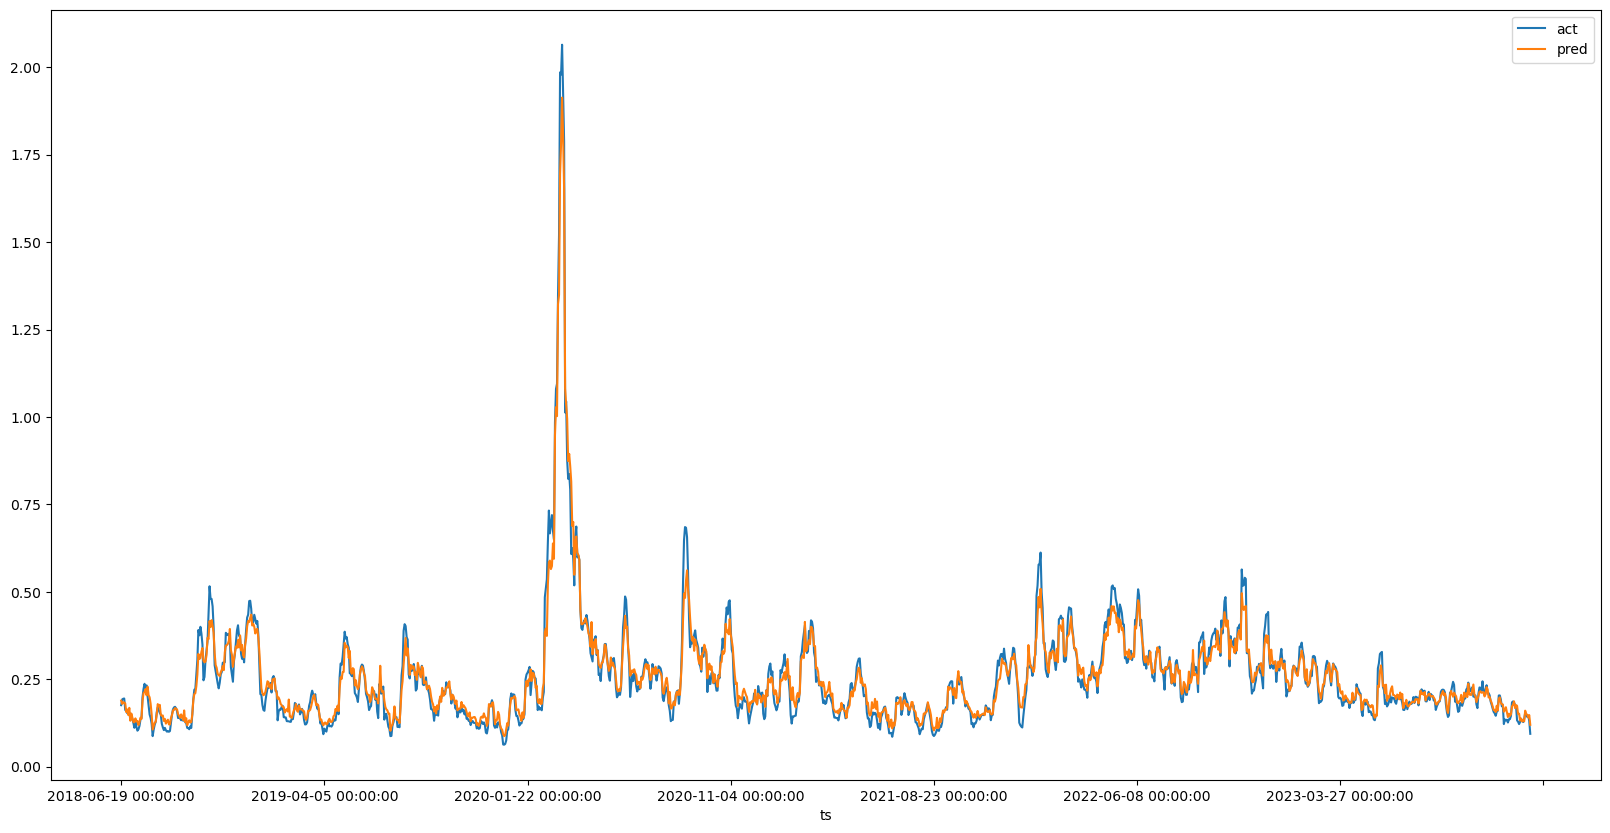

In [24]:
pd.DataFrame({'act': y, 'pred': best_model.predict(X)}).plot(figsize=(20, 10))

The average cross-validated RMSE is better than the one we saw in class(-0.068) for predicting the 5-day volatility of XLK.

#### Learning curve

<module 'matplotlib.pyplot' from '/Users/haritjaiswal/anaconda3/lib/python3.11/site-packages/matplotlib/pyplot.py'>

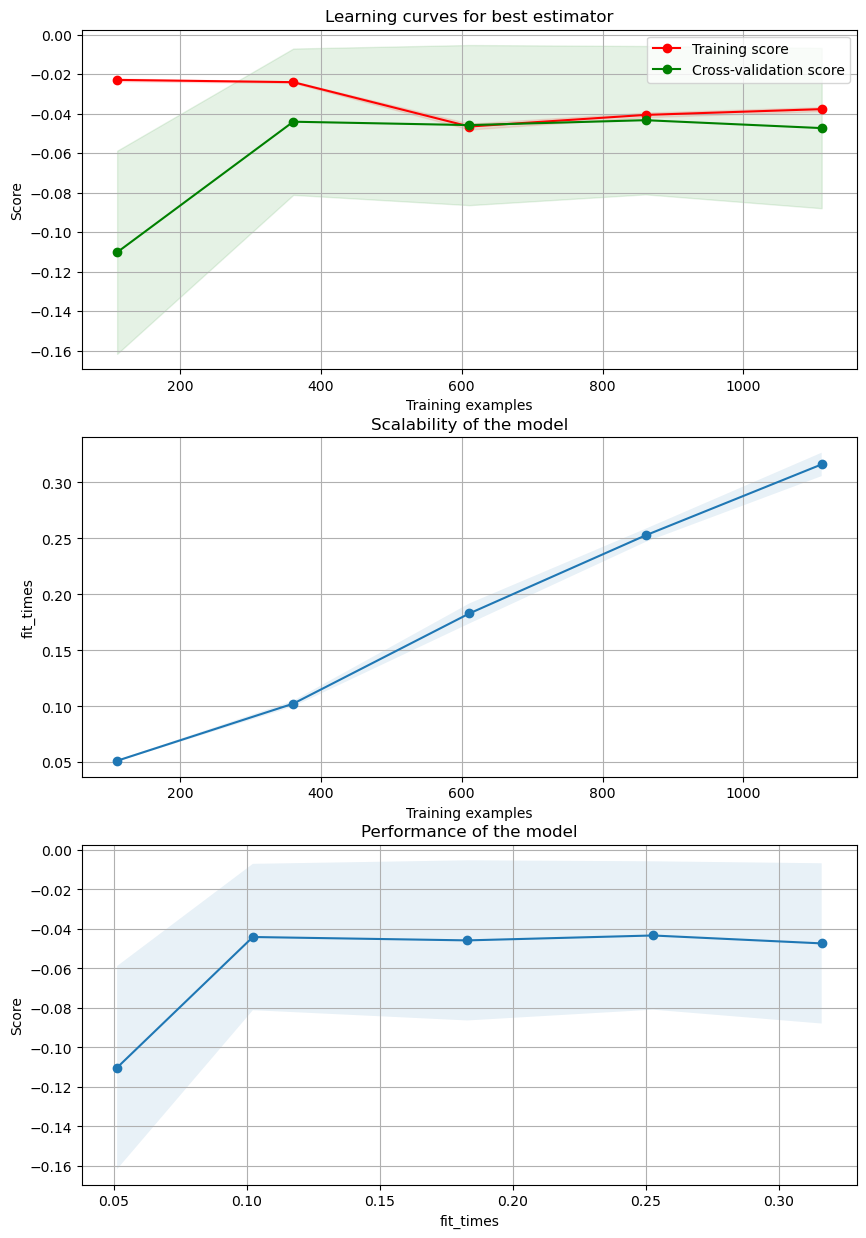

In [25]:
fig, axes = plt.subplots(3, 1, figsize=(10, 15))

title = "Learning curves for best estimator"

plot_learning_curve(
    best_model, title, X, y, axes=axes, cv=cv, n_jobs=4, scoring=scorer
)


For high training samples, the training and cross-validation scores converge. The fit time increases almost linearly with the number of training samples. The performance of the model does not seem to improve after 400 samples and stays constant.

#### Dumping model

In [26]:
pickle.dump(best_model, open('best_model.pkl', 'wb'))

In [27]:
loaded_model = pickle.load(open('best_model.pkl', 'rb'))

In [28]:
loaded_model == best_model

False

In [31]:
loaded_model.predict(X.iloc[[-1]])

array([0.11963702])

In [32]:
best_model.predict(X.iloc[[-1]])

array([0.11963702])

In [33]:
loaded_model

Pipeline(steps=[('feature_selector',
                 FeatureSelector(columns=['vol_XLK', 'cret_XLK', 'vo_lag_1_XLK',
                                          'vol_lag_5_XLK', 'vol_lag_10_XLK',
                                          'vol_lag_15_XLK'])),
                ('impute', KNNImputer()), ('scale', StandardScaler()),
                ('pca', PCA()), ('model', RandomForestRegressor())])